# Passos previs
Primer s'han d'instal·lar els paquets de Python necessaris. Es necessari instal·lar la llibreria __pymongo__ per la connexio a MongoDB i la __sshtunnel__ per fer el tunel. A l'assignatura hem preparat el paquet __GABDConnect__ que instal·la aquestes dues dependències i us facilitarà la connexió a al infraestructura de càlcul. També s'ha d'instal·lar el paquet __geonames-lib__ per la importació de les dades de [geonames](https://www.geonames.org/). A més, a la secció de "Secrets" del Colab, haureu d'afegir les variables de les dades de connexió al servidor de MongoDB i del tunel de SSH privades del vostre grup per que pugueu obrir les connexions.

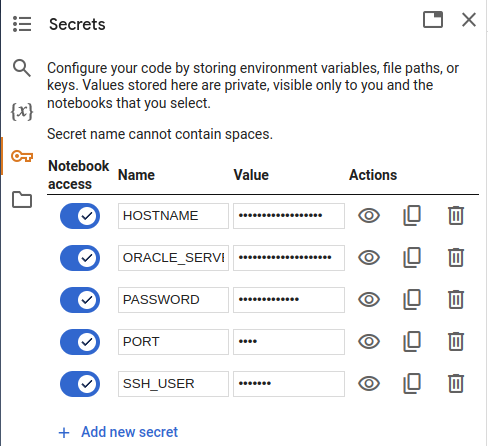

In [1]:
# @title Install or Update GABDConnect Libraries

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Function to install required packages
def install_packages(b):
    """
    Function to install or update necessary Python packages.

    Parameters:
    - b: Button object. Click event handler.
    """
    clear_output(wait=True)
    !pip install --upgrade pip -q  
    !pip install  git+https://github.com/Oriolrt/GABDConnect ucimlrepo -q 
    !pip install html2text -q  
    !pip install git+https://github.com/abmyii/geonames.git -q
    print("Libraries have been downloaded or updated.")

install_packages(True)



Libraries have been downloaded or updated.


In [2]:
from GABDConnect import mongoConnection
from pymongo import errors

# Connexió a MongoDB
Inicialitzem les variables amb els valors guardats a la secció de "Secrets" com hem explicat a l'inici. La variable DSN conté les dades del __servidor__, __port__ i __bd_name__ necesaris per fer la connexió a MongoDB.


In [3]:
import os
import logging

# Configurar el logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

# Crear un manejador de consola
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.WARNING)

# Crear un formatador i afegir-lo al manejador
formatter = logging.Formatter('%(levelname)s:%(message)s')
console_handler.setFormatter(formatter)

# Funció per detectar si s'està executant en Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    from google.colab import userdata

    # Inicialitzem el diccionari amb les dades de connexió SSH per fer el túnel
    SSH_USER = userdata.get('')
    SSH_TUNNEL = userdata.get('')

    HOSTNAME = userdata.get('')
    PORT = userdata.get('')
    PWD = userdata.get('')

    # Dades per fer el túnel SSH
    ssh_server = {'ssh': SSH_TUNNEL, 'user': SSH_USER,
                  'pwd': PWD, 'port': PORT} if SSH_TUNNEL is not None else None


else:
    # Inicialitzem el diccionari amb les dades de connexió SSH per fer el túnel
    SSH_USER = os.getenv('student')
    SSH_TUNNEL = os.getenv('dcccluster.uab.cat')

    HOSTNAME = os.getenv('main.grup15.gabd')
    PORT = os.getenv('8207')
    PWD = os.getenv('M22WhDiLUi7i.')

    # Dades per fer el túnel SSH
    ssh_server = {'ssh': SSH_TUNNEL, 'user': SSH_USER,
                  'pwd': PWD, 'port': PORT} if SSH_TUNNEL is not None else None

# Dades de connexió a MongoDB
user = "SYS"           # @param {type:str} Segons s'indica a l'enunciat de la pràctica
pwd = "SYS"            # @param {type:str} Poseu aquí la contrasenya que hagueu assignat a l'usuari gestorUCI
bd_name = "Practica_3"    # @param {type:str} Nom de la base de dades de test
col_name = "geonames" #   @param {type:str} de la col·lecció de prova
local_port = 27017 # @param {type: int} port local del tunnel ssh

# Exercici: Inserció de dades
Haureu d'acabar d'implementar la funció _insertGeonames_, la qual rebrà el _handler_ a la  **collection** on haureu d'inserir les dades de __GeoNames__.

In [4]:
#@title
import urllib.request as request
import zipfile
import os
from tqdm import tqdm
from pymongo import HASHED
from datetime import datetime

def download_file(nameDataset):
  # Download US geonames dataset
  extract_to = os.getcwd()
  file_path = f"{extract_to}/{nameDataset}.txt"
  zip_path = os.path.join(extract_to, f'{nameDataset}.zip')
  url = f"http://download.geonames.org/export/dump/{nameDataset}.zip"
  if not os.path.exists(zip_path):
    request.urlretrieve(url, zip_path)
    print(f"Descarregat {zip_path}")
  else:
    print(f"El fitxer {file_path} ja s'ha descarregat.")

  # Descomprimir el fitxer zip
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
    print(f"Descomprimit a {extract_to}")

  return file_path

def insertBigFiles(collection,nameDataset, *args, **kwargs):
  # Adapted from https://stackoverflow.com/a/34499197
  columns = {
      'geonameid': float,
      'name': str,
      'asciiname': str,
      'alternatenames': str,
      'latitude': float,
      'longitude': float,
      'featureclass': str,
      'featurecode': str,
      'countrycode': str,
      'countrycode2': str,
      'admin1code': str,
      'admin2code': str,
      'admin3code': str,
      'admin4code': str,
      'population': float,
      'elevation': float,
      'dem': float,  # dem (digital elevation model)
      'timezone': str,
      'modificationdate': str
  }
  collection.create_index([("geonameid", HASHED)], name="geonameid", sparse= True)
  fileName = kwargs['fileName']

  try:
    with tqdm(total=os.path.getsize(fileName)) as pbar:
      pbar.set_description(nameDataset)
      with open(fileName,'r', encoding='utf-8') as fp:
        for line in fp:
          pbar.update(len(line))
          line = line.split('\t')
          doc = {k: v for k, v in zip(columns, line) if len(v) > 0}
          doc['location'] = {'type': "Point", 'coordinates': [float(doc['longitude']), float(doc['latitude'])]}
          doc.pop('longitude', None)
          doc.pop('latitude', None)
          if 'elevation' in doc:
            doc["elevation"] = int(doc["elevation"])
          if 'geonameid' in doc:
            doc["geonameid"] = int(doc["geonameid"])
            doc["_id"] = doc["geonameid"]

          if "modification date" in doc:
            doc["modification date"] = datetime.strptime(doc["modification date"].strip('\n'), '%Y-%m-%d')

          res = collection.delete_one({'geonameid': doc['geonameid']})
          doc.pop('geonameid')

          res = collection.update_one({'_id': doc['_id']},{ "$set" : doc },upsert=True)

    return True
  except Exception as e:
    print(e)
    return False



In [5]:
from  geonames import GeoNames
import urllib.request as request
import zipfile
import math
import os
from pymongo import HASHED
from datetime import datetime




def insertGeonames(collection, nameDataset, *args, **kwargs):
  """
    Inserts the contents stored in the specified dataset into the MongoDB collection.

    Parameters:
    :param collection: handle to the MongoDB collection where data will be inserted.
    :param nameDataset: name of the dataset to be inserted into the database.
    :param args: additional positional arguments.
    :param kwargs: additional keyword arguments.
    :return: Boolean value indicating whether the data have been properly inserted into the database.
  """

  file_path = download_file(nameDataset)

  if nameDataset == "allCountries":
    return insertBigFiles(collection,nameDataset,fileName=file_path)



  # Load data
  print(f"Carregant les dades de {nameDataset} a Geonames ")
  with open(file_path, 'r', encoding='utf-8') as file:
    geo = GeoNames(file).data
  # TODO: elimina el "head(10)" del bucle següent per carregar totes les dades
  for index, row in geo.iterrows():
  # for index, row in geo.head(10).iterrows():
    
    row_dict = row.to_dict()
    # Assignar el camp geonameid com a _id
    row_dict['_id'] = int(row_dict.pop('geonameid'))
    # neteja els valors nan
    row_dict = {k: v for k, v in row_dict.items() if not (isinstance(v, str) and v.lower() == 'nan')}
    row_dict = {k: v for k, v in row_dict.items() if not (isinstance(v, str) and v.lower() == '')}
    row_dict = {k: v for k, v in row_dict.items() if not (isinstance(v, float) and math.isnan(v))}



    # Inserir el diccionari a MongoDB
    # TODO: feu la crida a  collection.update_one per inserir/actualitzar row_dict a la col·lecció "collection"
    try:
      collection.update_one(
        {"_id": row_dict['_id']},
        {"$set": row_dict},
        upsert=True
      )
      #print(f"S'ha inserit/Actualitzat {row_dict}")
    except Exception as e:
      print(f"Error al insertar {row_dict}: {e}")

  return True


# Carrega de dades

Les següents cel·les de codi s'encarreguen d'executar el cos principal (__main__) de codi. Essencialment no haureu de fer res excepte si voleu canviar el conjunt de dades de Geonames  a inserir:

```python
["US", "ES", "allCountries", "cities1500"]
```

Si voleu inserir altres conjunt de dades, o inserir-ne menys mentre feu proves, haureu de canviar aquesta llista.


In [6]:
# Cridem el constructor i obrim la connexió
# client = mongoConnection(user=user, pwd=pwd, hostname=HOSTNAME,
#                          ssh_data=ssh_server, db=bd_name,
#                          local_port=local_port)
client = mongoConnection(
    user="gestorGeonames",
    pwd="gestorGeonames",
    hostname="main.grup15.gabd",
    ssh_data={'ssh': "dcccluster.uab.cat", 'user': "student", 'pwd': "M22WhDiLUi7i.", 'port': 8207},
    db="Practica_3",
    local_port=27017
)

if not client.isStarted:
  client.open()


Connexió SSH a main.grup15.gabd oberta. S'ha obert un túnel a través de dcccluster.uab.cat al port 27017. La instrucció equivalent per fer-ho manualment seria: 
ssh -L   27017:main.grup15.gabd:27017 student@dcccluster.uab.cat -p 8207
Connexió a MongoDB oberta.


In [7]:
name="allCountries" # @param {type:str} ["US", "ES", "allCountries", "cities1500"]

bd = client.conn[bd_name]
# creeem una col·lecció si no existeix
try:
  col = bd[col_name]
except:
  col = bd.create_collection(col_name)

res = insertGeonames(col, name )

if res:
  logging.warning(f"Dades a {name} carregades correctament.")
else:
  logging.warning(f"Les Dades a {name} no s'han inserit correctament.")




El fitxer c:\Users\albee\Downloads/allCountries.txt ja s'ha descarregat.
Descomprimit a c:\Users\albee\Downloads


allCountries:   3%|▎         | 43941051/1715455451 [40:48<25:52:14, 17947.36it/s]


KeyboardInterrupt: 

In [ ]:
if  client.isStarted:
  client.close()

i no us oblideu de tancar la connexió.

